<a href="https://colab.research.google.com/github/pachterlab/picasso/blob/main/examplePicasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Download Example Data Matrix**

In [ ]:
import requests
import os

#La Manno et al. 2020, Developing Mouse Brain data
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2067 metadata.csv")
os.system("mv D1.2071 smartseq.mtx")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


0

In [ ]:
!git clone https://github.com/pachterlab/picasso.git

Cloning into 'picasso'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 4), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [ ]:
%cd /content/picasso

/content/picasso


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 127 kB 7.2 MB/s 
     |████████████████████████████████| 7.7 MB 6.1 MB/s 
     |████████████████████████████████| 80 kB 12.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.0 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 


## **Install Packages**

In [ ]:
from Picasso import Picasso

import anndata 
import pandas as pd
import numpy as np

import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../'

pcs = 50
n_latent = 50

Numpy matrix for input (3850 cells x 1999 genes)

In [ ]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

Metadata to color cells/points

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


Set colors for plotting (list of colors for 3850 cells)

In [ ]:
clus_colors = list(pd.unique(meta.smartseq_cluster_color))


Function for plotting latent space with cells colored by given labels

In [ ]:
def obj_plot_embed(latent, cluster_label, fname = None, colors = [], alpha=0.4,figsize=(7,5)):
	""" Plot latent space in 2D and color cells by cluster_label """

	fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=figsize)
	#cm.get_cmap("tab20")
	cluster_labels = pd.unique(cluster_label)

	cmap = np.random.rand(len(cluster_labels),3)

	for i, c in (enumerate(cluster_labels)):

		XX = latent[cluster_label == c,:]
		x = XX[:,0]
		y = XX[:,1]

		if(len(colors) >= len(cluster_labels)):
			color = colors[i]
		else:
			color = cmap[i,:]

		ax.scatter(x, y, s=5, alpha = alpha, label=c, color = color)
		
	ax.legend(loc='center left',bbox_to_anchor=(1, 0.5),prop={'size': 8},frameon=False,ncol=2)
	ax.set_axis_off()

	fig.tight_layout()
	if(fname != None):
		plt.savefig(fname)
	else:
		plt.show()

### **Run Picasso**

#### **Define your own shape coordinates**

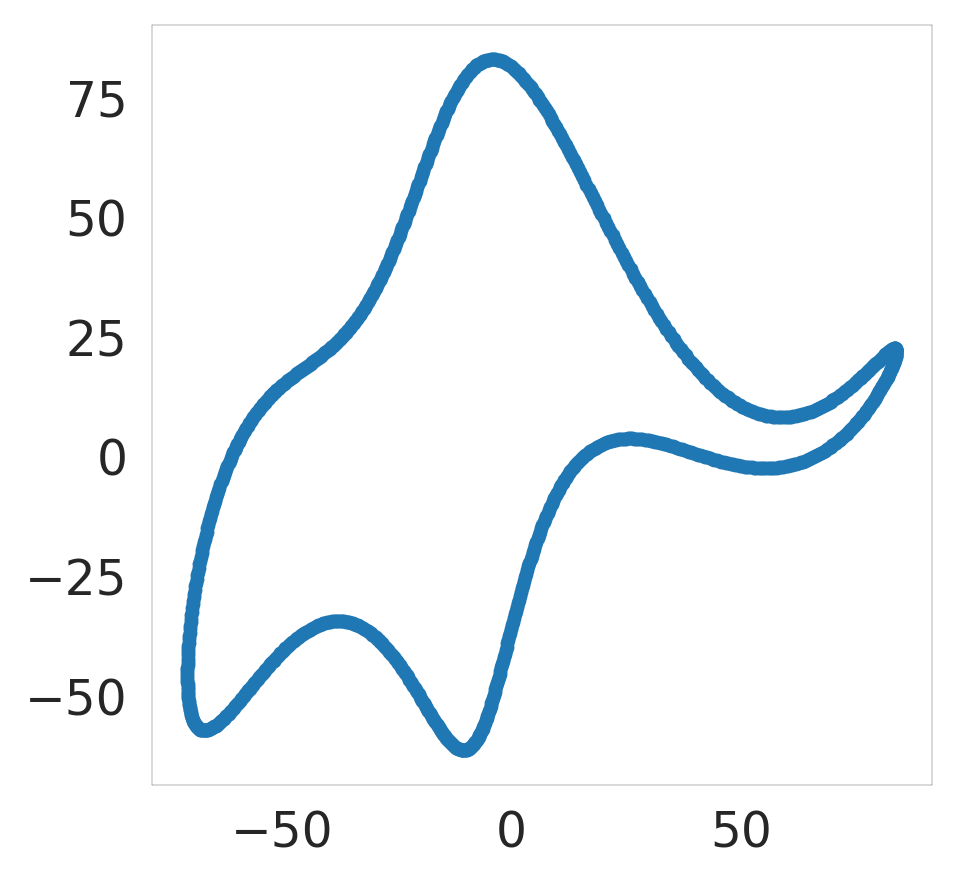

In [ ]:
# elephant parameters
#From https://aapt.scitation.org/doi/full/10.1119/1.3254017 (Mayer et al. 2010)
batch_size = 1000 #any number < n_obs in data matrix


p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    # x = np.append(fourier(t,Cx), [-p5.imag]) #[-p5.imag]
    # y = np.append(fourier(t,Cy), [p5.imag]) #[p5.imag]
    x = fourier(t,Cx)
    y = fourier(t,Cy)

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,batch_size), p1, p2, p3, p4, p5)

#Make array input for dimension of shape 


coords = np.array([list(y),list(-x)])

plt.plot(y,-x,'.')
plt.show()


In [ ]:
coords.shape

(2, 1000)

**Run Picasso with coordinates**

In [ ]:
#Run Picasso
p = Picasso(n_latent = 2, epochs = 500, batch_size = batch_size)

#Get losses and latent space representation
lossesEl, latentEl = p.fit(scaled_mat,coords, frac = 0.15,silent=True,ret_loss=True) #frac





Plot output

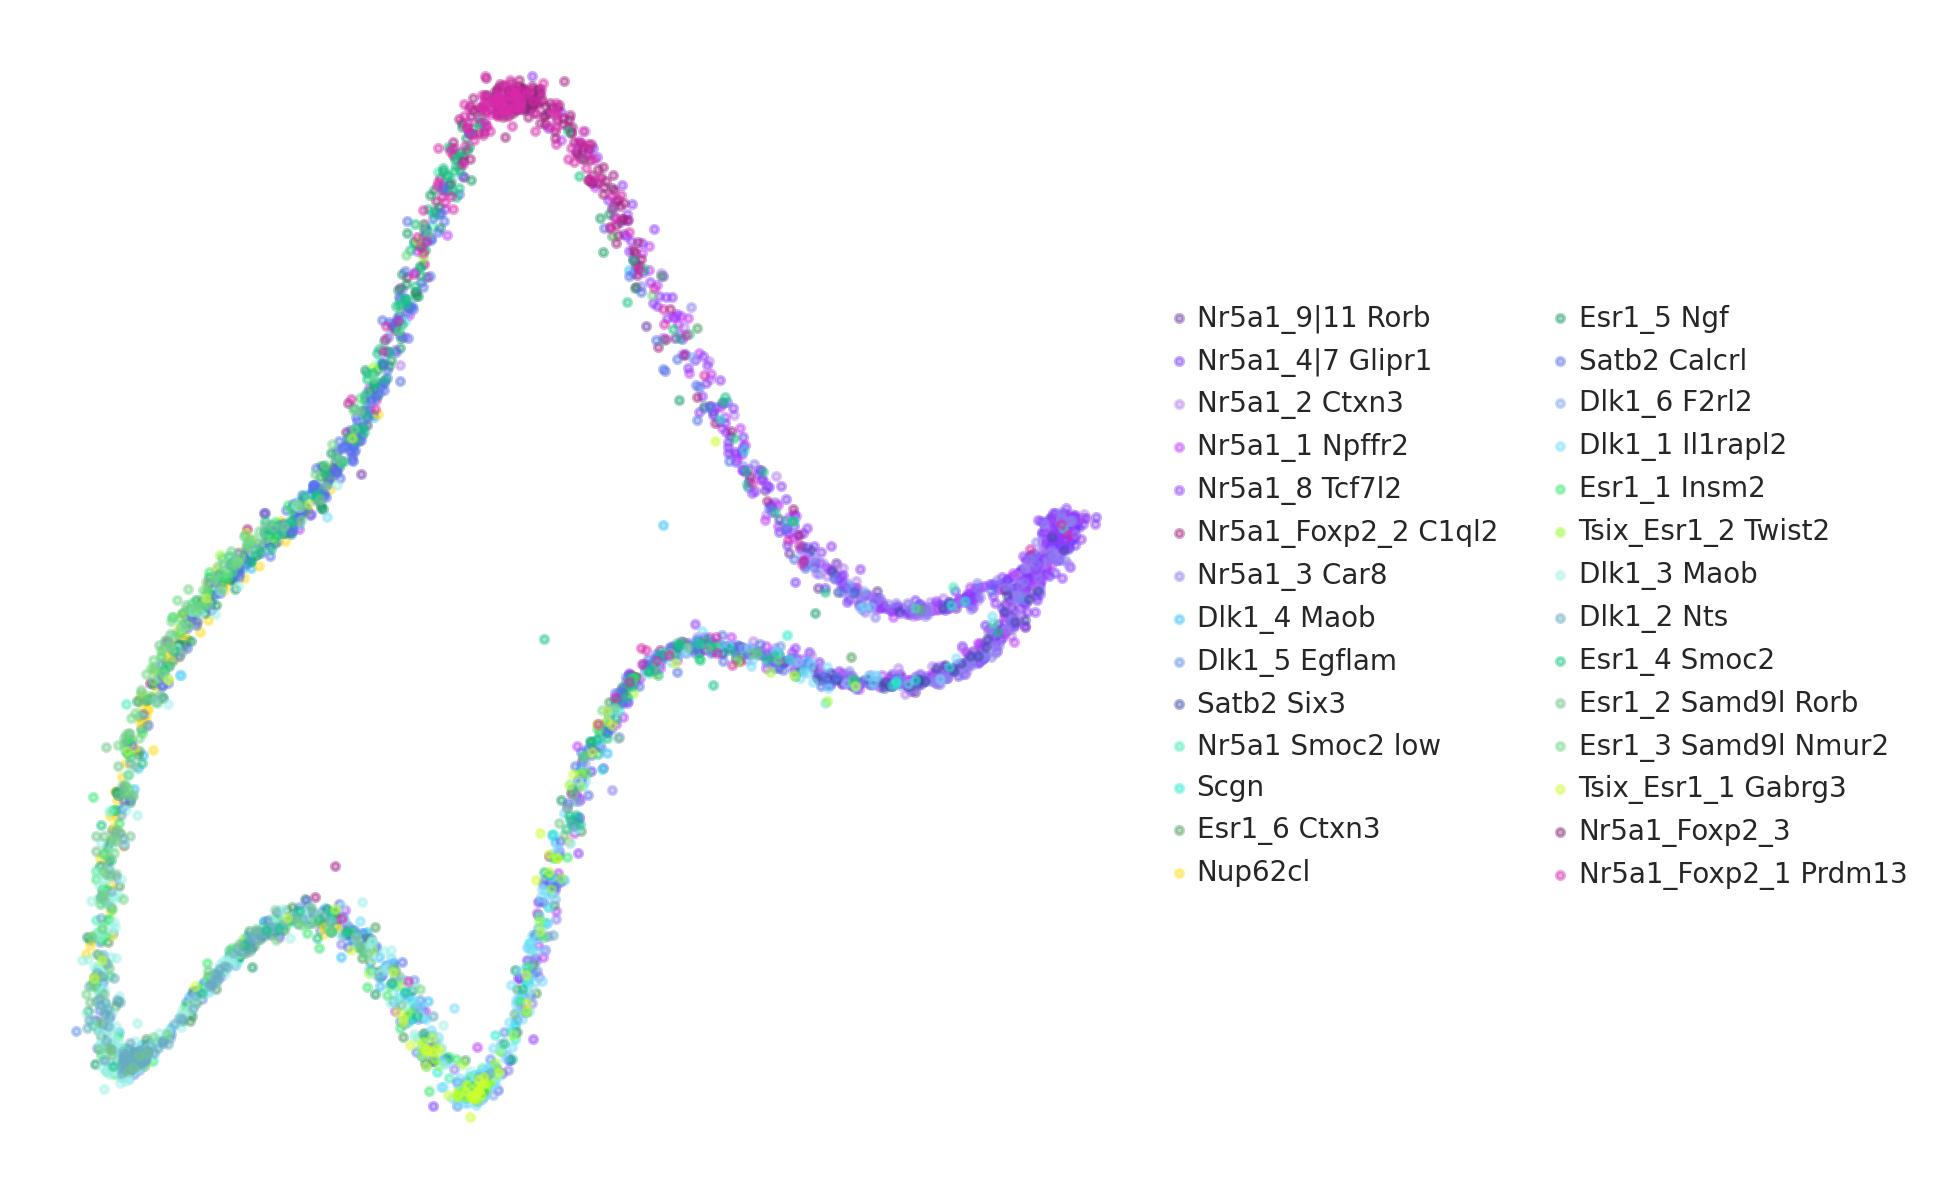

In [ ]:
obj_plot_embed(latentEl, meta.smartseq_cluster, fname = 'picasso.pdf', colors=clus_colors ,figsize=(8,5))

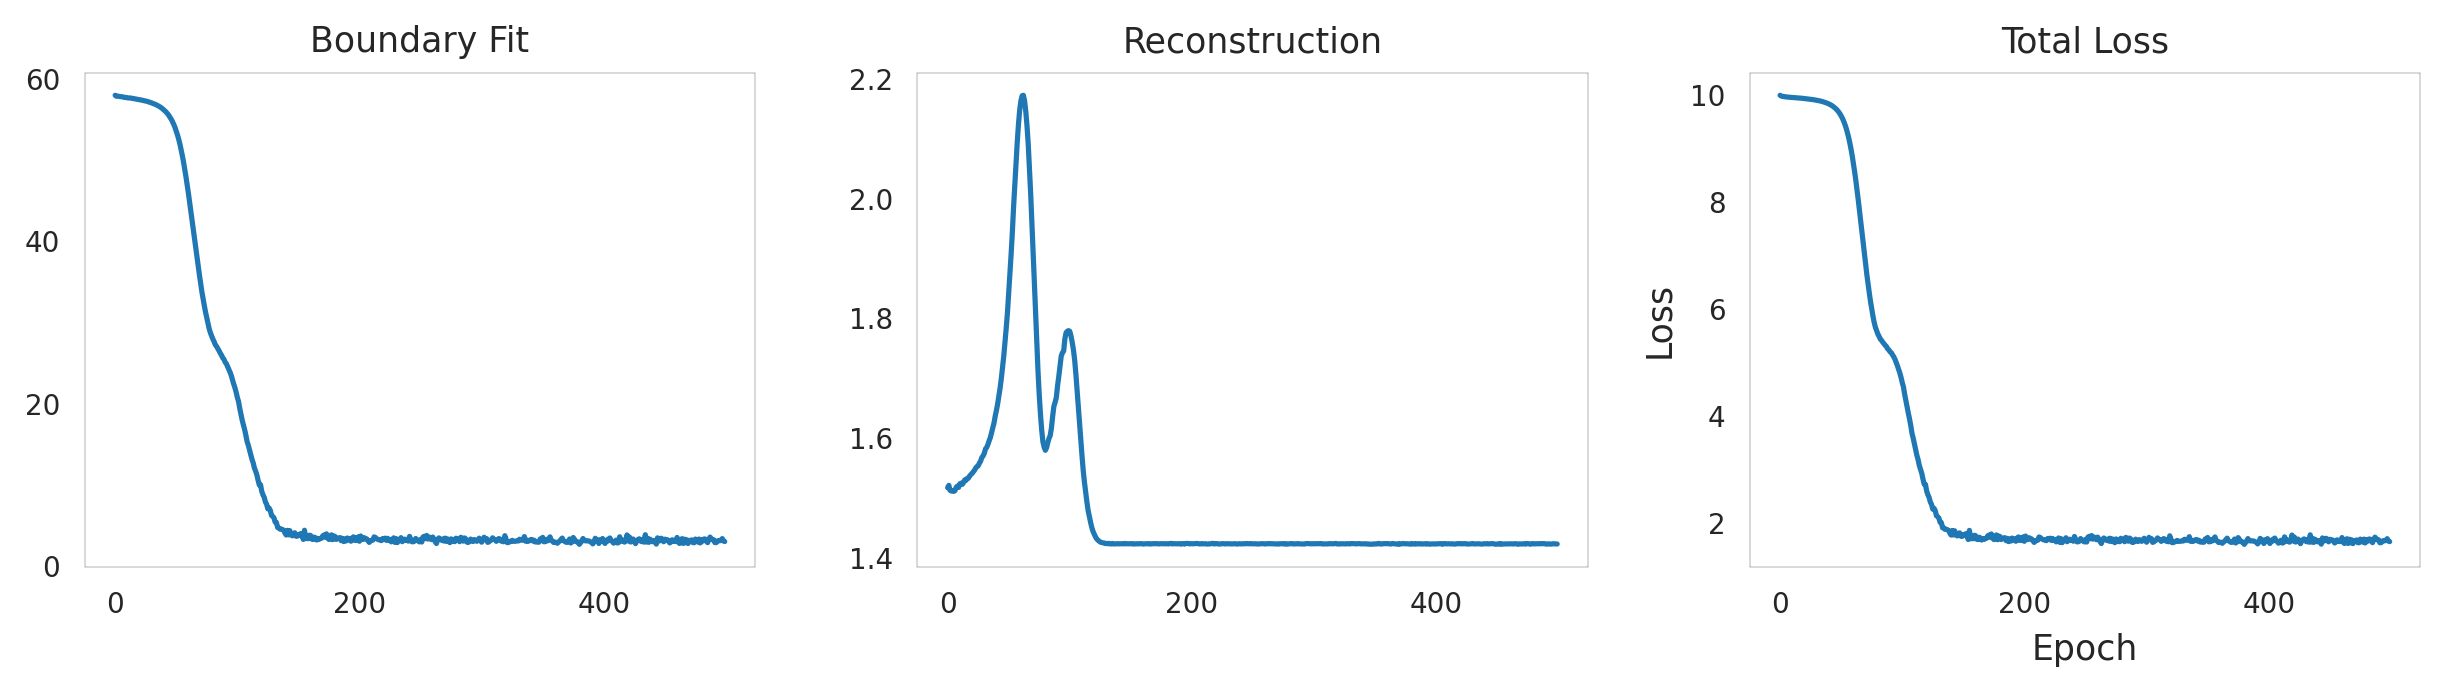

In [ ]:
p.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

#### **Use coordinates from external source/script**

**Load coordinates**

See [here](https://github.com/pachterlab/picasso/tree/main/map) to generate coordinates along boundary of image

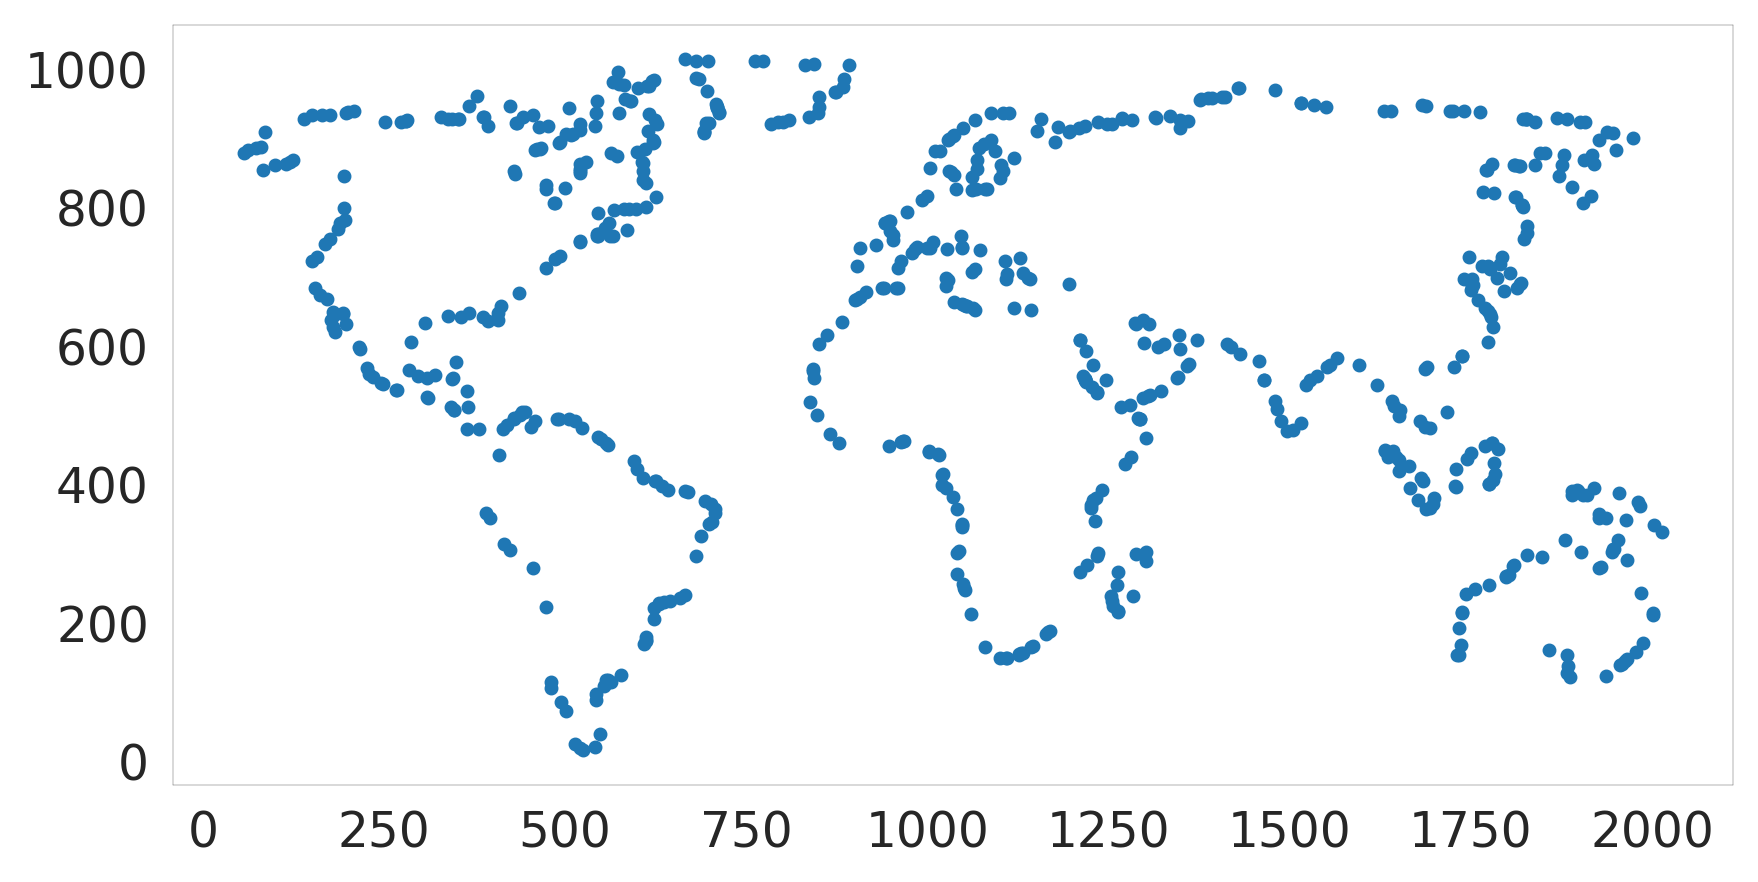

In [ ]:
# Map parameters
pts = pd.read_csv('./map/mapPoints700.csv',header=None)
pts.head()

x = pts[0]
y = pts[1]
coords = np.array([x,y])

plt.figure(figsize=(8,4))
plt.plot(x,y,'.')
plt.show()


In [ ]:
coords.shape

(2, 700)

In [ ]:
#Run Picasso
batch_size = len(x)


p = Picasso(n_latent = 2, epochs = 1000, batch_size = batch_size)
  
#Get losses and latent representation
lossesMap, latentMap = p.fit(scaled_mat,coords, frac = 0.44,silent=True,ret_loss=True) #44




Plot Picasso embedding and color cells by labels

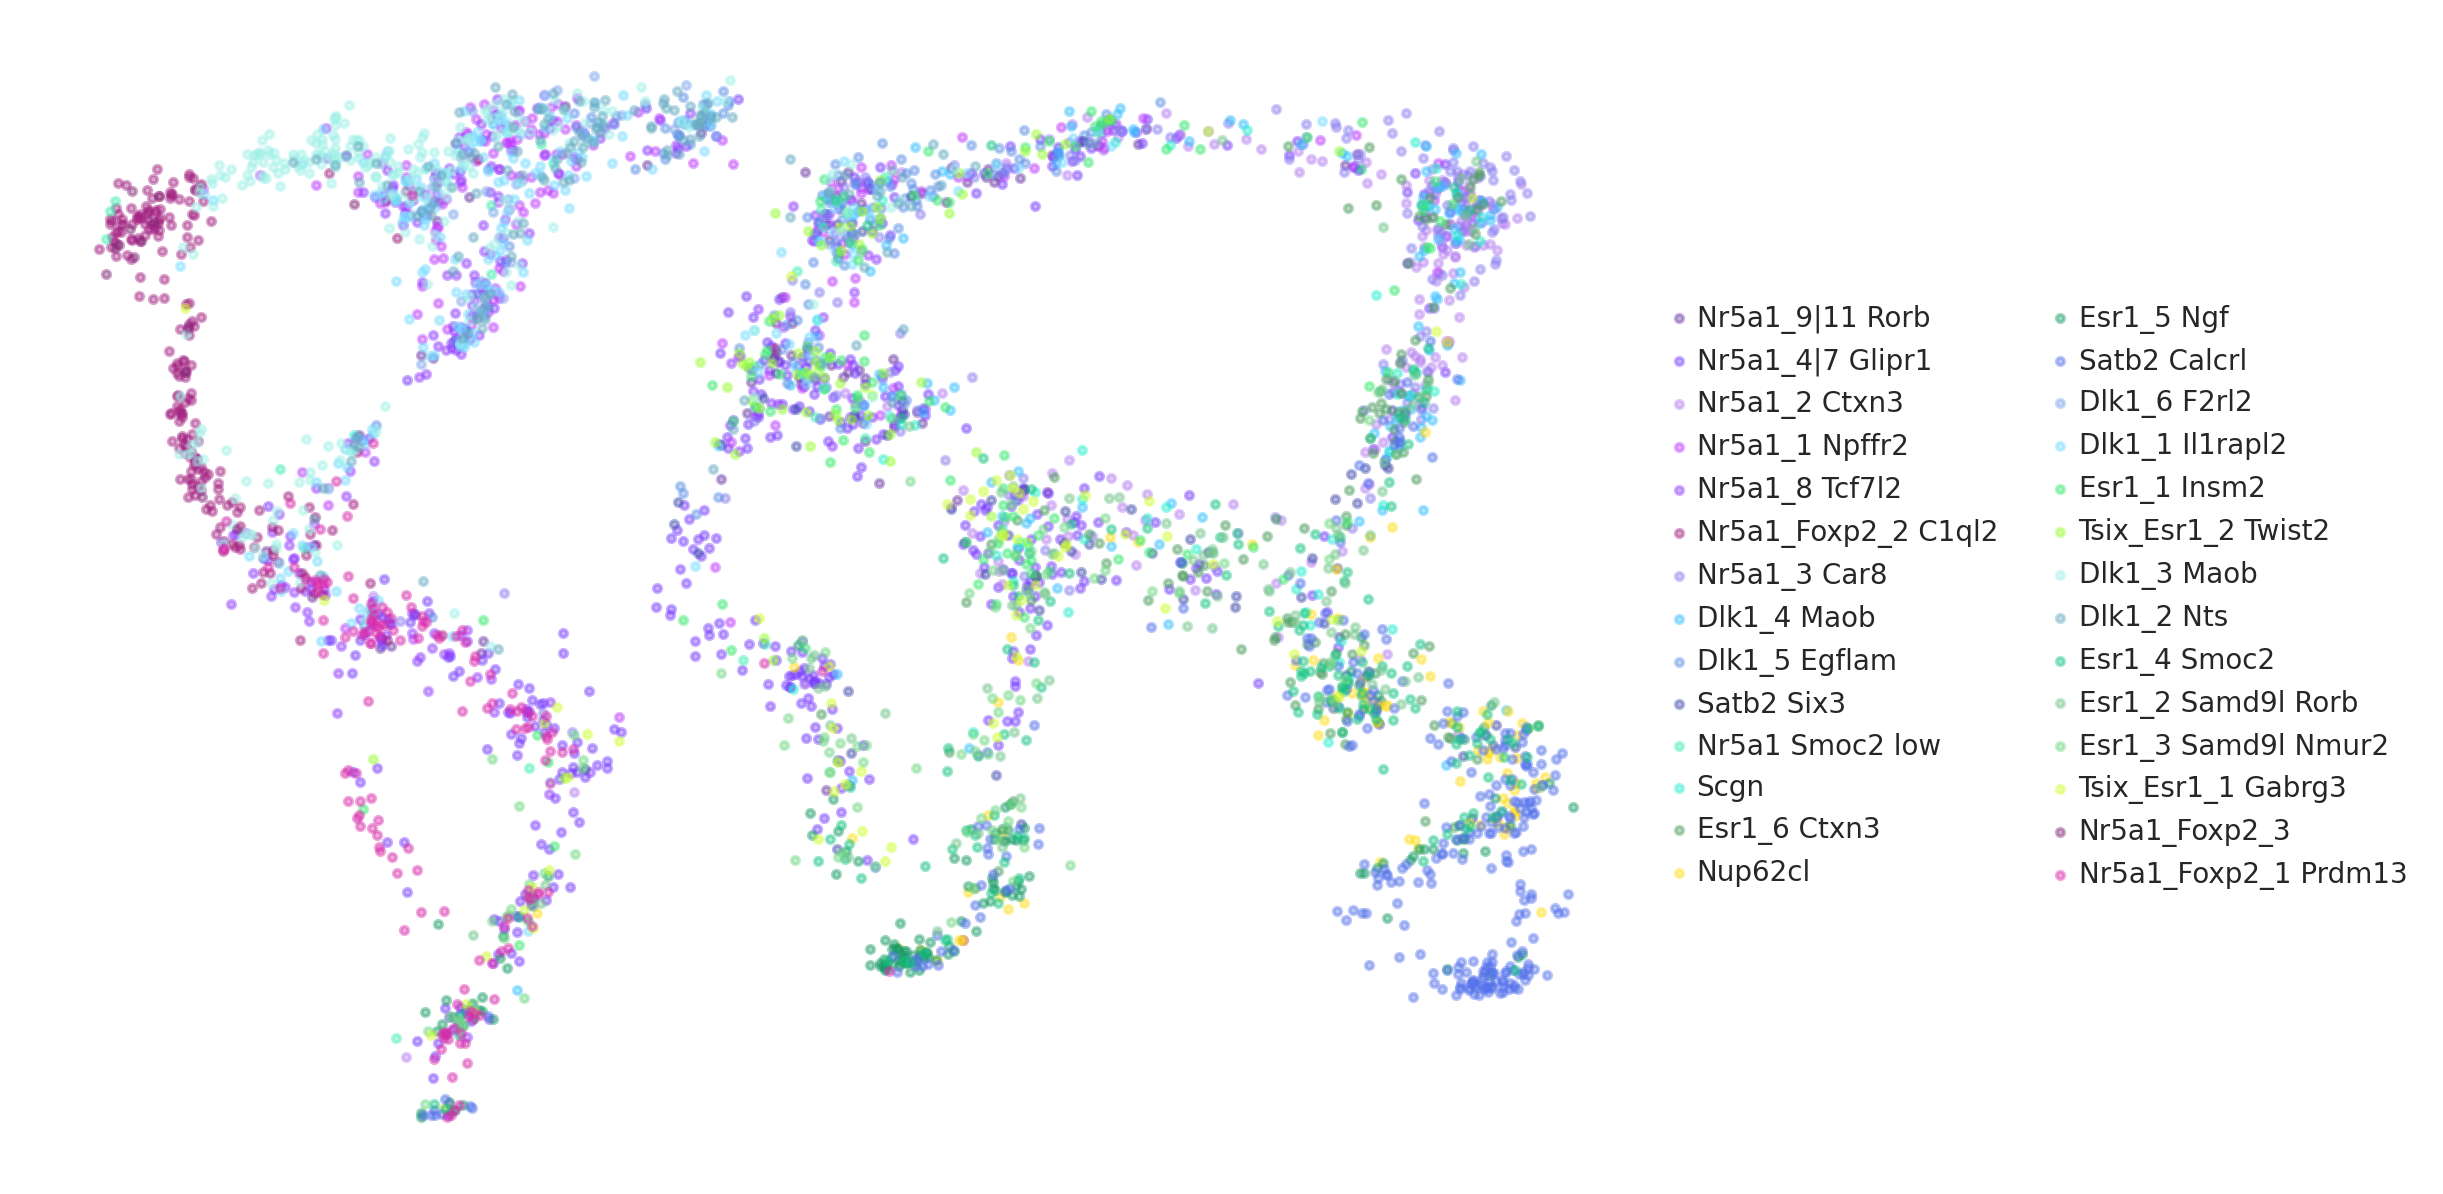

In [ ]:
obj_plot_embed(latentMap,  meta.smartseq_cluster, fname = 'picasso.pdf', colors=clus_colors,figsize=(10,5) )

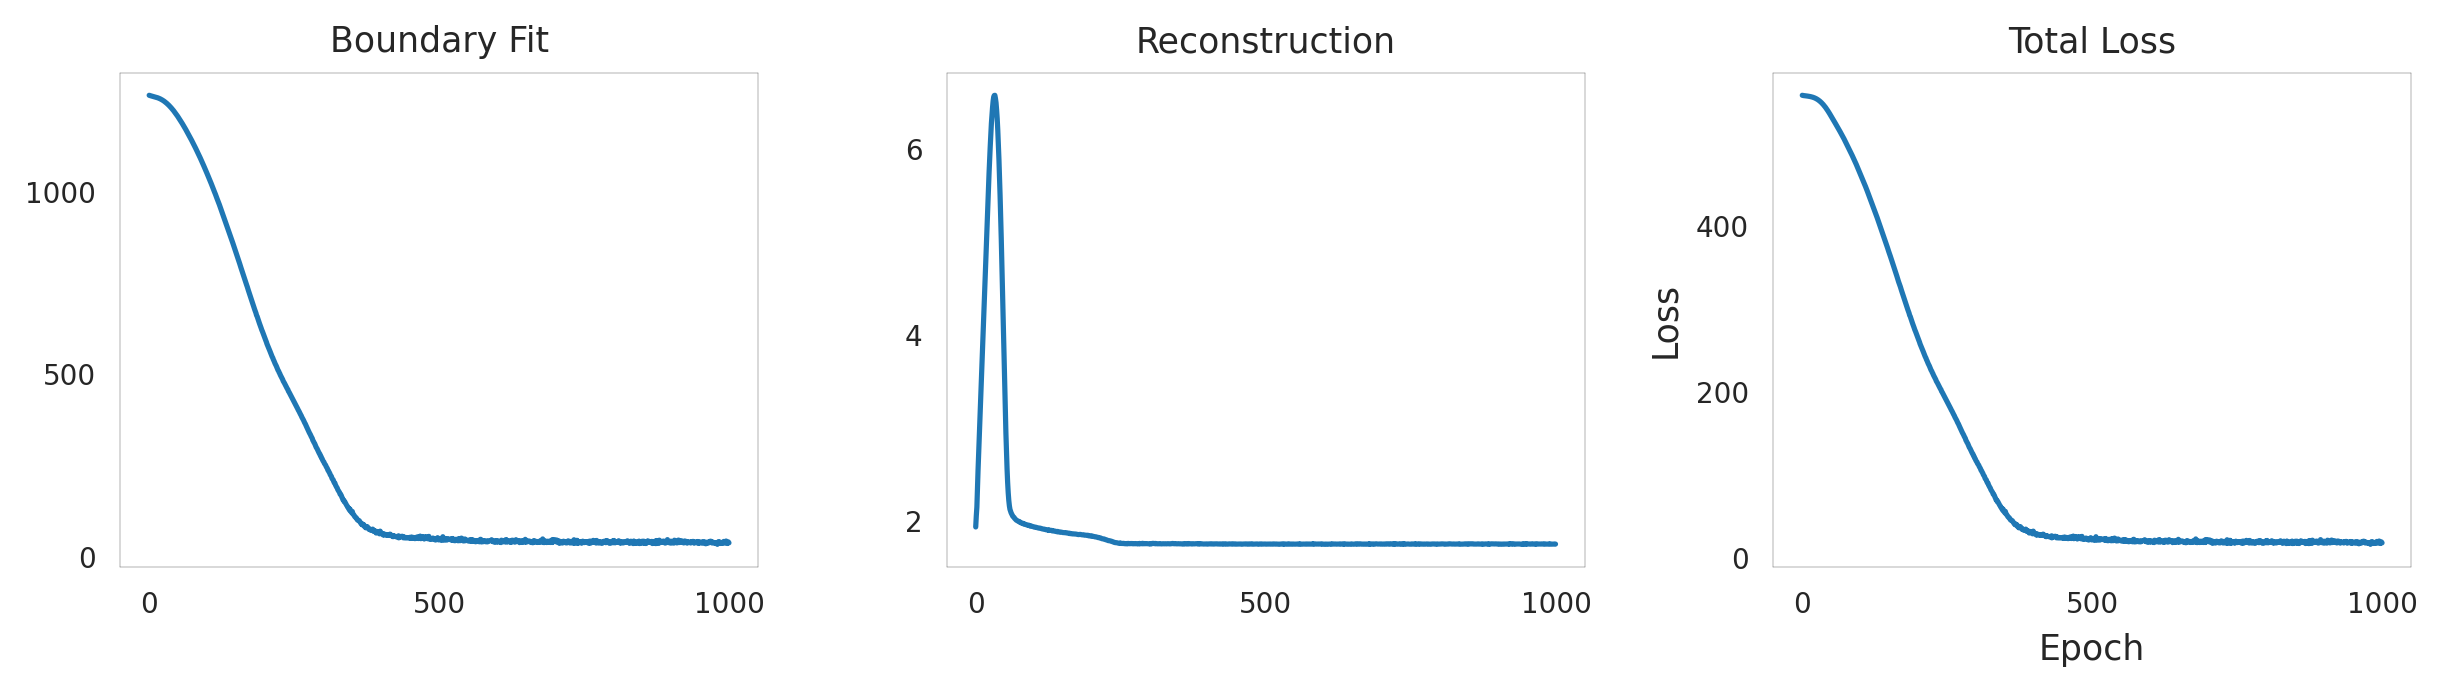

In [ ]:
p.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)